# Step 1: Import Libraries

In [2]:
!pip install xgboost

     ------------------------------------- 150.0/150.0 MB 10.4 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import re

# Step 2: Load Data

In [64]:
train_df = pd.read_csv("dataset/train_data_car_estimation.csv")
test_df = pd.read_csv("dataset/test_data_car_estimation.csv")

# Step 3: Data Cleaning

In [65]:
def clean_data(df):
    df = df.copy()

    # Drop unnecessary columns only if they exist
    df.drop(['Unnamed: 0', 'New_Price'], axis=1, inplace=True, errors='ignore')

    # Handle missing values
    df['Seats'].fillna(df['Seats'].mode()[0], inplace=True)
    df['Mileage'].fillna("0 kmpl", inplace=True)
    df['Engine'].fillna("0 CC", inplace=True)
    df['Power'] = df['Power'].replace("null bhp", np.nan)
    df['Power'].fillna("0 bhp", inplace=True)

    # Clean string columns and convert to numeric
    df['Mileage'] = df['Mileage'].str.extract(r'([0-9.]+)').astype(float)
    df['Engine'] = df['Engine'].str.extract(r'([0-9.]+)').astype(float)
    df['Power'] = df['Power'].str.extract(r'([0-9.]+)').astype(float)

    return df

train_df = clean_data(train_df)
test_df = clean_data(test_df)

C:\Users\parth\AppData\Local\Temp\ipykernel_18512\1130224925.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Seats'].fillna(df['Seats'].mode()[0], inplace=True)
C:\Users\parth\AppData\Local\Temp\ipykernel_18512\1130224925.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



# Step 4: Feature Engineering

In [66]:
def preprocess(df):
    df = df.copy()
    df['Car_Name'] = df['Name'].apply(lambda x: x.split(' ')[0])
    df.drop(['Name'], axis=1, inplace=True)
    
    # Encode categorical variables
    df = pd.get_dummies(df, columns=['Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Car_Name'], drop_first=True)
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)

# Align train and test sets (in case of missing dummy columns)
test_df = test_df.reindex(columns=train_df.columns.drop('Price'), fill_value=0)

# Step 5: Visualization

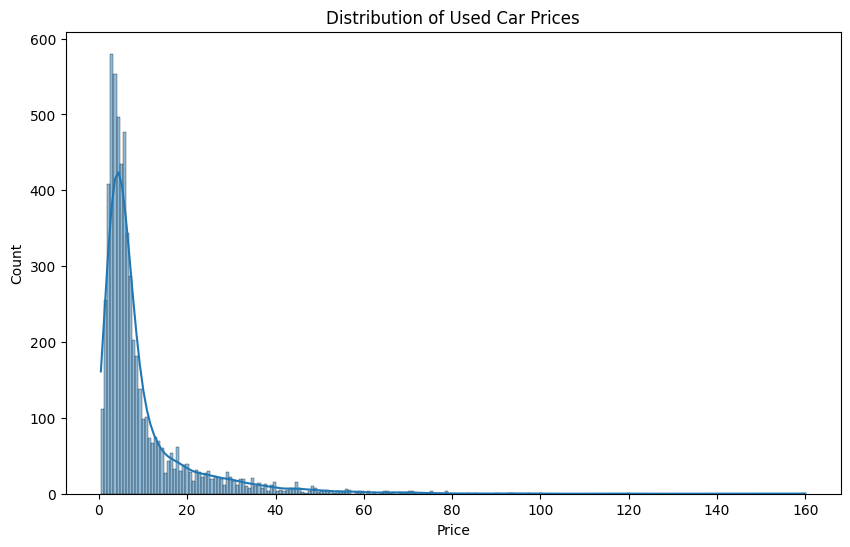

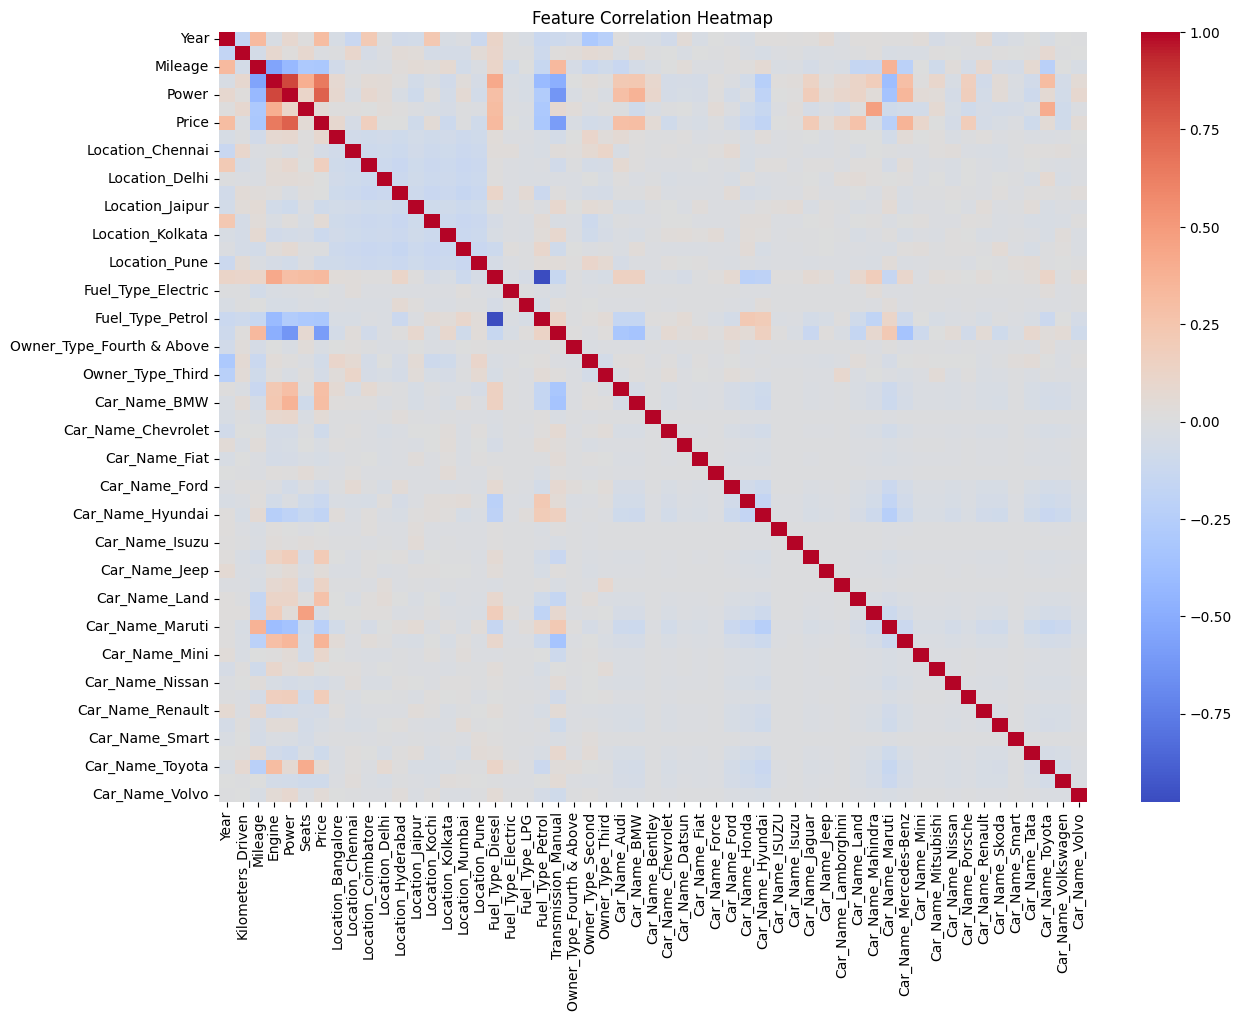

In [56]:
# Step 5: Visualization
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Price'], kde=True)
plt.title("Distribution of Used Car Prices")
plt.show()

# Correlation heatmap
plt.figure(figsize=(14,10))
sns.heatmap(train_df.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [67]:
import joblib

# Save the column names used in training
joblib.dump(X.columns.tolist(), "X_columns.pkl")
print("✅ X_columns.pkl saved")


✅ X_columns.pkl saved


# Step 6: Model Training

In [68]:
X = train_df.drop('Price', axis=1)
y = train_df['Price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

# Step 7: Evaluation

In [69]:
y_pred = model.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R² Score: 0.8986
RMSE: 3.5318


# Step 8: Predicting on Test Set

In [70]:
test_predictions = model.predict(test_df)
print("Sample predictions on test set:", test_predictions[:5])

Sample predictions on test set: [ 2.8766053  3.3751695 18.734804   4.1329546  4.4333763]


# Step 9: Predict for test input

In [71]:
def predict_price(model, user_input_df):
    # Preprocess same as before
    user_input_df = clean_data(user_input_df)
    user_input_df = preprocess(user_input_df)
    user_input_df = user_input_df.reindex(columns=X.columns, fill_value=0)
    
    pred_price = model.predict(user_input_df)
    return pred_price[0]

# Example: Predict price for a single test sample
sample_input = test_df.iloc[[0]]
predicted_price = model.predict(sample_input)[0]
print(f"Predicted price for sample input: ₹{predicted_price:.2f} Lakhs")


Predicted price for sample input: ₹2.88 Lakhs


# Step 10: Predict for user input

In [62]:
def get_user_input_from_terminal():
    print("Please enter the following car details:\n")
    Name = input("Car Name (e.g., Maruti Swift Dzire): ")
    Location = input("Location (e.g., Mumbai): ")
    Year = int(input("Year of Manufacture (e.g., 2017): "))
    Kilometers_Driven = int(input("Kilometers Driven (e.g., 45000): "))
    Fuel_Type = input("Fuel Type (Petrol/Diesel/CNG/LPG/Electric): ")
    Transmission = input("Transmission (Manual/Automatic): ")
    Owner_Type = input("Owner Type (First/Second/Third/Fourth & Above): ")
    Mileage = input("Mileage (e.g., 18.9 kmpl): ")
    Engine = input("Engine (e.g., 1197 CC): ")
    Power = input("Power (e.g., 82 bhp): ")
    Seats = int(input("Seats (e.g., 5): "))

    user_input = {
        'Name': Name,
        'Location': Location,
        'Year': Year,
        'Kilometers_Driven': Kilometers_Driven,
        'Fuel_Type': Fuel_Type,
        'Transmission': Transmission,
        'Owner_Type': Owner_Type,
        'Mileage': Mileage,
        'Engine': Engine,
        'Power': Power,
        'Seats': Seats
    }

    return pd.DataFrame([user_input])


# Get user input
user_df = get_user_input_from_terminal()

# Predict
predicted_price = predict_price(model, user_df)
print(f"\n✅ Predicted Price for your car: ₹{predicted_price:.2f} Lakhs\n")


Please enter the following car details:


✅ Predicted Price for your car: ₹10.32 Lakhs



C:\Users\parth\AppData\Local\Temp\ipykernel_18512\1130224925.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Seats'].fillna(df['Seats'].mode()[0], inplace=True)
C:\Users\parth\AppData\Local\Temp\ipykernel_18512\1130224925.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



# Step 11: Save the model

In [63]:
import joblib

# Save the trained model to a file
joblib.dump(model, "xgb_model.pkl")

print("✅ Model saved as xgb_model.pkl")

✅ Model saved as xgb_model.pkl
